<a href="https://colab.research.google.com/github/SonolaMoyo/HamoyeSummer2022/blob/main/classification_using_tensorflow_amazon_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from subprocess import check_output
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import seaborn as sns
print(check_output(["ls", "../input"]).decode("utf8"))

Kaggle-planet-test-tif.torrent
Kaggle-planet-train-tif.torrent
sample_submission_v2.csv
test_v2_file_mapping.csv
train_v2.csv



In [ ]:
sample = pd.read_csv('../input/sample_submission_v2.csv/sample_submission_v2.csv')
print(sample.shape)
sample.head()

(61191, 2)


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [ ]:
df = pd.read_csv('../input/train_v2.csv/train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


So, we are given around 40.000 training images.

In [ ]:
df.shape

(40479, 2)

# Tag counts


In [ ]:
all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {}'.format(1.0*len(all_tags)/df.shape[0]))

total of 116278 non-unique tags in all training images
average number of labels per image 2.8725511993873365


In [ ]:
tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
tags_counted_and_sorted.head()

,tag,0
12,primary,37513
5,clear,28431
0,agriculture,12315
13,road,8071
16,water,7411


<AxesSubplot:ylabel='tag'>

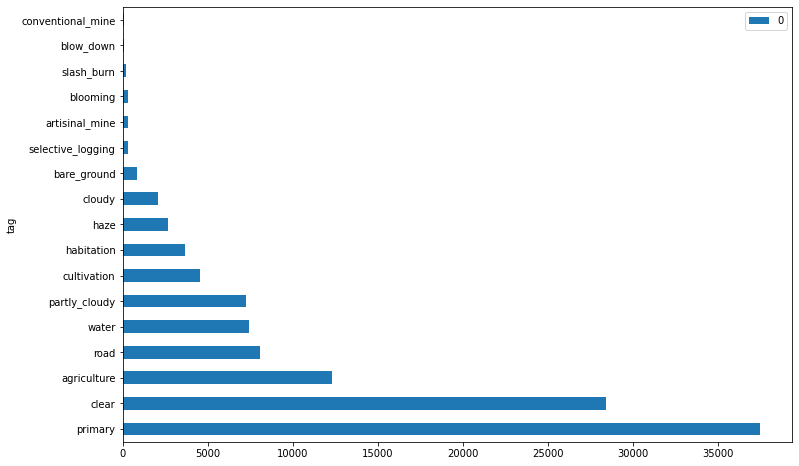

In [ ]:
tags_counted_and_sorted.plot.barh(x='tag', y=0, figsize=(12,8))

# Looking at the actual images

In [ ]:
from glob import glob
image_paths = sorted(glob('../input/train-jpg/*.jpg'))[0:1000]
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))
image_names[0:10]

[]

In [ ]:
# plt.figure(figsize=(12,8))
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.imshow(plt.imread(image_paths[i]))
#     plt.title(str(df[df.image_name == image_names[i]].tags.values))

It seems, that all of the images are of the same size, which would make preprocessing them much easier.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score, precision_score, make_scorer, average_precision_score
import cv2
import warnings
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer


n_samples = 200
rescaled_dim = 20

df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(df['split_tags'])
y = y[:n_samples]
# X = np.squeeze(np.array([cv2.resize(plt.imread('../input/train-jpg/{}.jpg'.format(name)), (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1) for name in df.head(n_samples)['image_name'].values]))
X = MinMaxScaler().fit_transform(X)

print(X.shape, y.shape, lb.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


In [ ]:

from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)


In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=1600, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(17, activation='sigmoid'))


2022-09-20 00:46:22.602702: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:

model.fit(X_train, y_train, epochs=50, batch_size=5000)

In [ ]:
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
X_sub = np.squeeze(np.array([cv2.resize(plt.imread('../input/test-jpg-v2/{}.jpg'.format(name)), (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1) for name in sample['image_name'].values]))
X_sub = MinMaxScaler().fit_transform(X_sub)
X_sub.shape


In [ ]:
y_sub = model.predict(X_sub)
y_sub.shape


In [ ]:
print(y_sub)

In [ ]:
test_tags = []
for index in range(y_sub.shape[0]):
    test_tags.append(' '.join(list(lb.classes_[np.where(y_sub[index, :] == 1)[0]])))



In [ ]:
sample.head()

In [ ]:
test_tags[0:20]

In [ ]:
sample['tags'] = test_tags
sample.head()

In [ ]:
image_paths = sorted(glob('../input/test-jpg-v2/*.jpg'))[0:1000]
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))
image_names[0:10]

In [ ]:
plt.figure(figsize=(12,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(plt.imread(image_paths[i]))
    plt.title(str(sample[sample.image_name == image_names[i]].tags.values))